In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium

offers = pd.read_csv('./data/data_orders.csv')
orders = pd.read_csv('./data/data_offers.csv')

# Quick scan of data

In [29]:
offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB


4 categorical columns - `order_datetime`, `order_gk`, `order_status_key`, `is_driver_assigned_key`

In [30]:
print(f"Size of offers: {offers.shape}")
print(f"Size of orders: {orders.shape}, {orders['order_gk'].nunique()} orders are unique and average {round(orders['order_gk'].value_counts().mean(), 3)} offers per order")

Size of offers: (10716, 8)
Size of orders: (334363, 2), 97967 orders are unique and average 3.413 offers per order


In [31]:
offers.sample(10, random_state=0)

order_datetime  origin_longitude  origin_latitude  m_order_eta  \
4041        22:31:50         -0.898989        51.443087          NaN   
9307        22:02:40         -0.974322        51.475264          NaN   
10264       22:47:09         -0.966605        51.450929          NaN   
6057        19:05:34         -0.951096        51.448692          NaN   
7072        02:42:26         -0.971735        51.456830          NaN   
1852        17:31:10         -0.981301        51.424127        659.0   
8764        08:26:48         -0.978027        51.454454          NaN   
4228        21:33:01         -0.912884        51.475161          NaN   
4847        18:22:35         -0.974819        51.461532         60.0   
10132       00:18:15         -0.954481        51.442852          NaN   

            order_gk  order_status_key  is_driver_assigned_key  \
4041   3000598786617                 4                       0   
9307   3000577501926                 4                       0   
10264  3000590756500                 9                       0   
6057   3000623067359                 9                       0   
7072   3000590905675                 4                       0   
1852   3000552370961                 4                       1   
8764   3000583466026                 4                       0   
4228   3000595721294                 9                       0   
4847   3000599962690                 4                       1   
10132  3000617554101                 4                       0   

       cancellations_time_in_seconds  
4041                            72.0  
9307                            61.0  
10264                            NaN  
6057                             NaN  
7072                           200.0  
1852                            30.0  
8764                           127.0  
4228                             NaN  
4847                            52.0  
10132                           30.0

- `order_datetime` is in local time format and should be converted to datetime instead of object for efficient memory and renamed to time to be more accurate
- `origin_longitude` and `origin_latitude` are in Decimal Degrees format
<!-- - `order_status_key` and `is_driver_assigned_key` usually to be converted to categorical variables for EDA purpose   -->
- Note that `order_gk` is not converted to categorical variable due to high cardinality (distinguish between *unique identifiers* and *categories*)

In [32]:
orders.sample(10, random_state=0)

order_gk      offer_id
266206  3000617451911  300051717981
18602   3000623090985  300051824594
68342   3000585116711  300051105031
269931  3000617050382  300051700329
301274  3000628634109  300052164141
90356   3000587030455  300051150122
50851   3000577152468  300050809897
160187  3000629282566  300052220858
329887  3000578650859  300050891463
187249  3000627956215  300052113919

# Clean data

<Axes: >

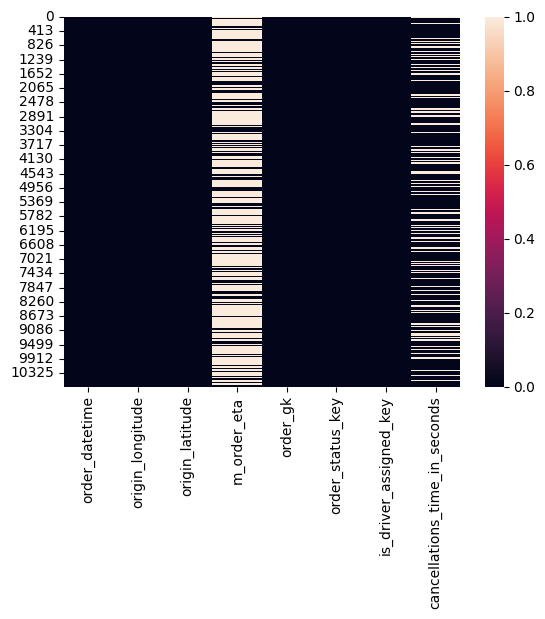

In [33]:
# check for missing values
sns.heatmap(offers.isna())

In [34]:
print(f"Missing values in offers:\n{offers.isna().sum()}")

Missing values in offers:
order_datetime                      0
origin_longitude                    0
origin_latitude                     0
m_order_eta                      7902
order_gk                            0
order_status_key                    0
is_driver_assigned_key              0
cancellations_time_in_seconds    3409
dtype: int64


- Missing values in `m_order_eta` is likely due to no driver assigned
- Missing values in `cancellations_time_in_seconds` could mean to denote cancelled in 0 seconds or passenger did not cancel and order is ultimately cancelled by system from timeout

In [35]:
# to confirm assumptions on missing values
if offers[offers['is_driver_assigned_key']==0]['m_order_eta'].isna().all() and offers[offers['is_driver_assigned_key']==0]['m_order_eta'].isna().sum()==offers['m_order_eta'].isna().sum():
    print(f"All missing values in `m_order_eta` are due to no driver assigned")

if (offers.query('cancellations_time_in_seconds.isna() & order_status_key==9').shape[0]) == (offers['cancellations_time_in_seconds'].isna().sum()) and offers[(offers['order_status_key']==9) & (offers['cancellations_time_in_seconds'].notna())].shape[0]==0:
    print(f"All missing values in `cancellations_time_in_seconds` are due to system cancellations")

All missing values in `m_order_eta` are due to no driver assigned
All missing values in `cancellations_time_in_seconds` are due to system cancellations


In [36]:
# convert datetime columns to datetime objects with dummy date to be more memory efficient
offers['order_datetime'] = pd.to_datetime(offers['order_datetime'], format='%X')
offers.rename(columns={'order_datetime': 'order_time'}, inplace=True)

In [37]:
# map values to clearer categories
offers['order_status_key'] = offers['order_status_key'].map({4: 'Client cancelled', 9: 'System cancelled'})
offers['is_driver_assigned_key'] = offers['is_driver_assigned_key'].map({0: 'No', 1: 'Yes'})

In [38]:
print(offers.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_time                     10716 non-null  datetime64[ns]
 1   origin_longitude               10716 non-null  float64       
 2   origin_latitude                10716 non-null  float64       
 3   m_order_eta                    2814 non-null   float64       
 4   order_gk                       10716 non-null  int64         
 5   order_status_key               10716 non-null  object        
 6   is_driver_assigned_key         10716 non-null  object        
 7   cancellations_time_in_seconds  7307 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 669.9+ KB
None


# EDA

In [39]:
offers.sample(10, random_state=0)

order_time  origin_longitude  origin_latitude  m_order_eta  \
4041  1900-01-01 22:31:50         -0.898989        51.443087          NaN   
9307  1900-01-01 22:02:40         -0.974322        51.475264          NaN   
10264 1900-01-01 22:47:09         -0.966605        51.450929          NaN   
6057  1900-01-01 19:05:34         -0.951096        51.448692          NaN   
7072  1900-01-01 02:42:26         -0.971735        51.456830          NaN   
1852  1900-01-01 17:31:10         -0.981301        51.424127        659.0   
8764  1900-01-01 08:26:48         -0.978027        51.454454          NaN   
4228  1900-01-01 21:33:01         -0.912884        51.475161          NaN   
4847  1900-01-01 18:22:35         -0.974819        51.461532         60.0   
10132 1900-01-01 00:18:15         -0.954481        51.442852          NaN   

            order_gk  order_status_key is_driver_assigned_key  \
4041   3000598786617  Client cancelled                     No   
9307   3000577501926  Client cancelled                     No   
10264  3000590756500  System cancelled                     No   
6057   3000623067359  System cancelled                     No   
7072   3000590905675  Client cancelled                     No   
1852   3000552370961  Client cancelled                    Yes   
8764   3000583466026  Client cancelled                     No   
4228   3000595721294  System cancelled                     No   
4847   3000599962690  Client cancelled                    Yes   
10132  3000617554101  Client cancelled                     No   

       cancellations_time_in_seconds  
4041                            72.0  
9307                            61.0  
10264                            NaN  
6057                             NaN  
7072                           200.0  
1852                            30.0  
8764                           127.0  
4228                             NaN  
4847                            52.0  
10132                           30.0

## 1. Distributions of failed orders by possible reasons to failure

### Reason 1: Lack of drivers assigned

Text(0.5, 1.0, 'Number of Offers by Driver Assignment and Order Status')

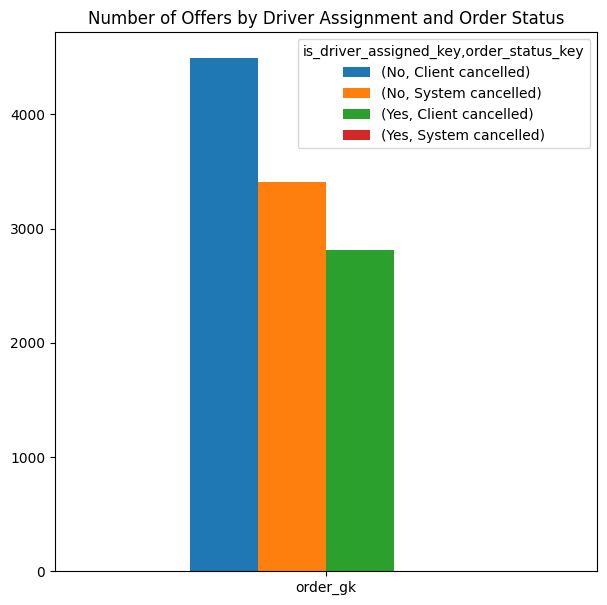

In [40]:
df_q1a = offers.pivot_table(columns=["is_driver_assigned_key", "order_status_key"], values="order_gk", aggfunc="count")
ax = df_q1a.plot(kind="bar", subplots=False, figsize=(7, 7), legend=True, rot=0)
ax.set_title("Number of Offers by Driver Assignment and Order Status")

In [41]:
offers.pivot_table(columns=["is_driver_assigned_key", "order_status_key"], values="order_gk", aggfunc="count")

is_driver_assigned_key               No                               Yes  \
order_status_key       Client cancelled System cancelled Client cancelled   
order_gk                           4496             3406             2811   

is_driver_assigned_key                   
order_status_key       System cancelled  
order_gk                              3

Most orders were cancelled before a driver was assigned.  
Among client cancelled orders, almost double were cancelled while no driver was assigned. This suggests that clients might have waited too long and tried other transportation instead.

### Reason 2: Estimated time of arrival is too long

Text(0.5, 1.0, 'Estimated Time of Arrival for Client Cancelled Orders with Driver Assigned')

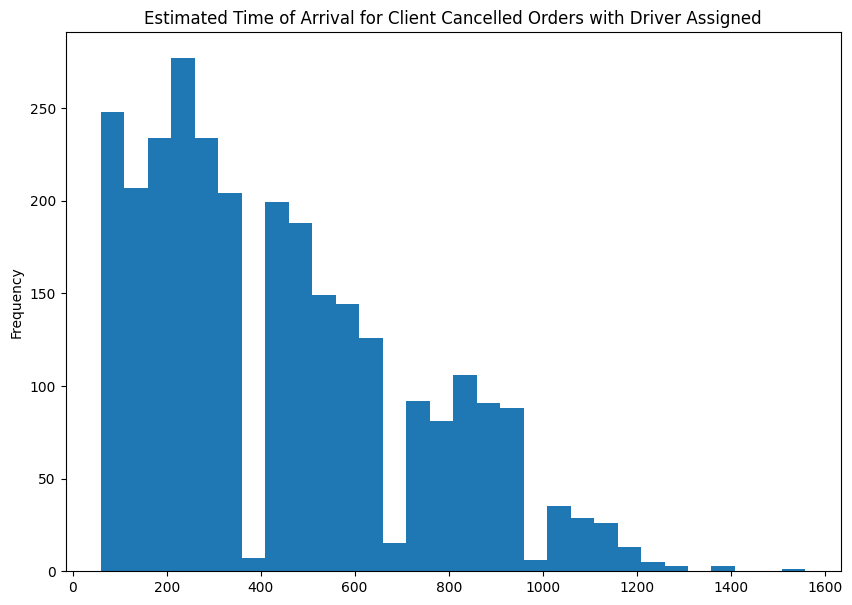

In [42]:
df_q1bi = offers[(offers['is_driver_assigned_key']=='Yes') & (offers['order_status_key']=='Client cancelled')]['m_order_eta']

ax = df_q1bi.plot(kind='hist', subplots=False, figsize=(10,7), bins=30)
ax.set_title("Estimated Time of Arrival for Client Cancelled Orders with Driver Assigned")

Text(0.5, 1.0, 'Estimated Time of Arrival for System Cancelled Orders with Driver Assigned')

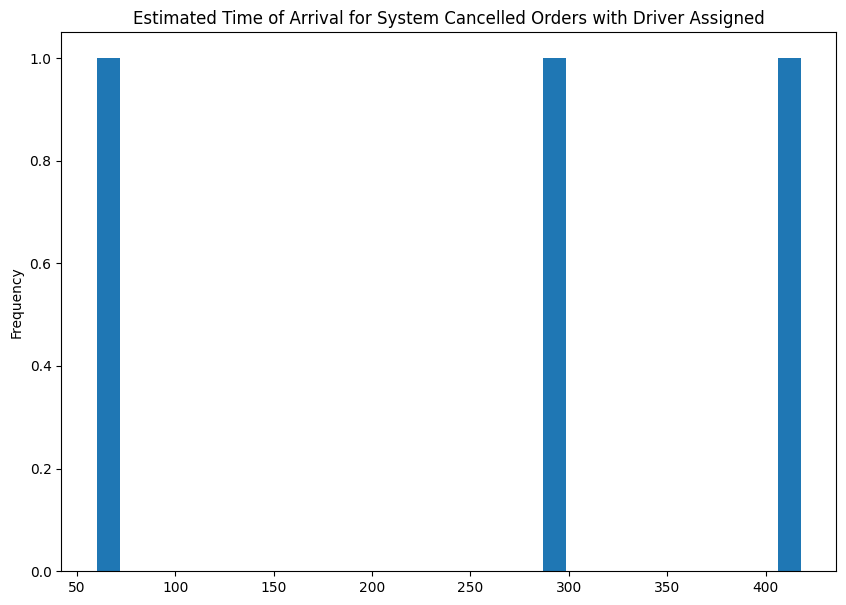

In [43]:
df_q1bii = offers[(offers['is_driver_assigned_key']=='Yes') & (offers['order_status_key']=='System cancelled')]['m_order_eta']

ax = df_q1bii.plot(kind='hist', subplots=False, figsize=(10,7), bins=30)
ax.set_title("Estimated Time of Arrival for System Cancelled Orders with Driver Assigned")

As estimated time of arrival increases, number of client cancelled offers dropped. This shows that estimated time of arrival being too long is not the main reason for client cancellation orders.  
A possible reason is the estimated time of arrival's correlation with traffic and weather conditions at the time of order. A long ETA could have been due to a poor weather condition and remote pick up for the driver to arrive, with lack of alternative transport options. Thus, less clients choose to cancel orders.

### Reason 3: Unsuitable pick up location

Text(0.5, 1.0, 'Pickup Locations for System Cancelled Orders')

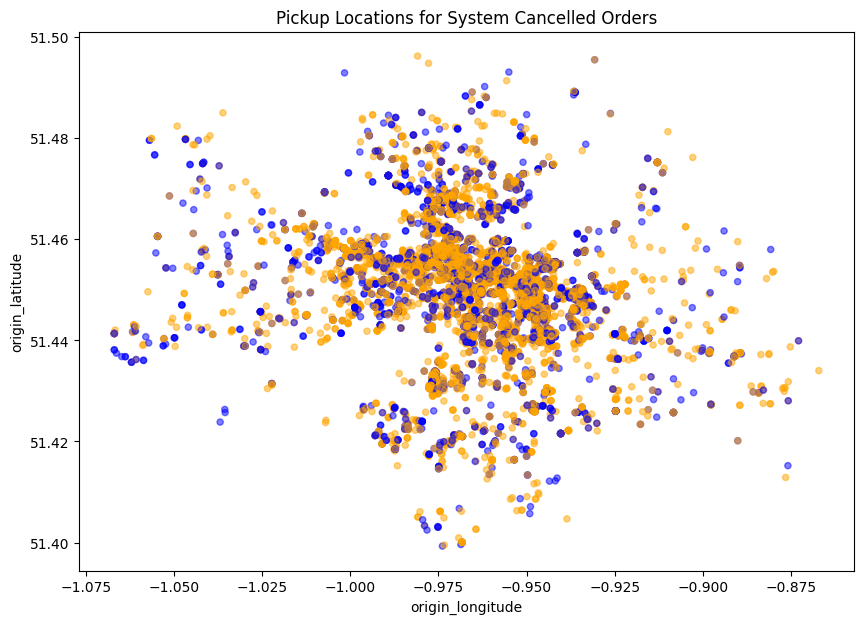

In [44]:
colourmap = {'Client cancelled': 'orange', 'System cancelled': 'blue'}

df_q1ci = offers.loc[:, ['origin_longitude', 'origin_latitude', 'order_status_key']]
df_q1ci['status_colour'] = df_q1ci['order_status_key'].map(colourmap)

ax = df_q1ci.plot(kind='scatter', x='origin_longitude', y='origin_latitude', c='status_colour', alpha=0.5, figsize=(10, 7), legend=True)
ax.set_title("Pickup Locations for System Cancelled Orders")

Text(0.5, 1.0, 'Pickup Locations for Client Cancelled Orders')

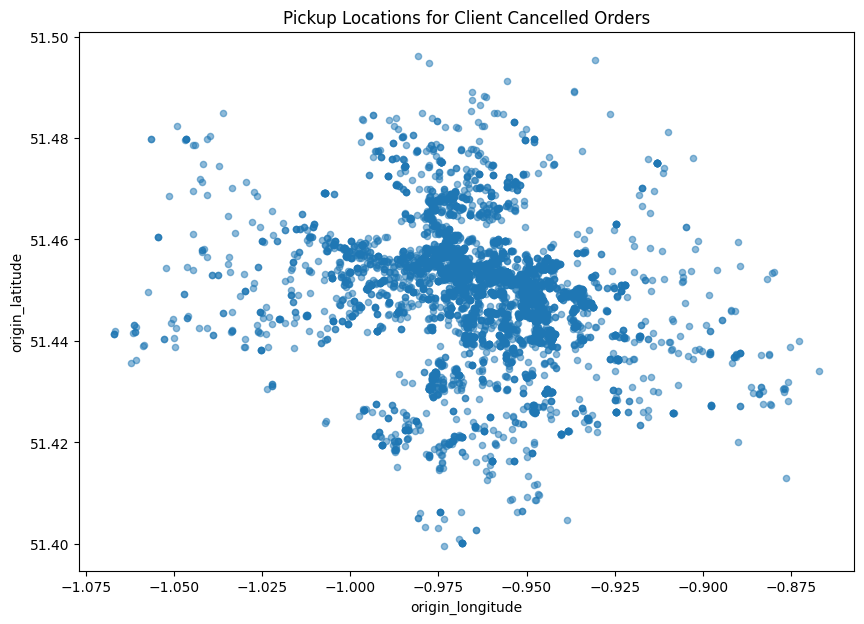

In [45]:
df_q1cii = offers[offers['order_status_key']=='Client cancelled'][['origin_longitude', 'origin_latitude']]
ax = df_q1cii.plot(kind='scatter', x='origin_longitude', y='origin_latitude', alpha=0.5, figsize=(10, 7))
ax.set_title("Pickup Locations for Client Cancelled Orders")

Text(0.5, 1.0, 'Pickup Locations for System Cancelled Orders')

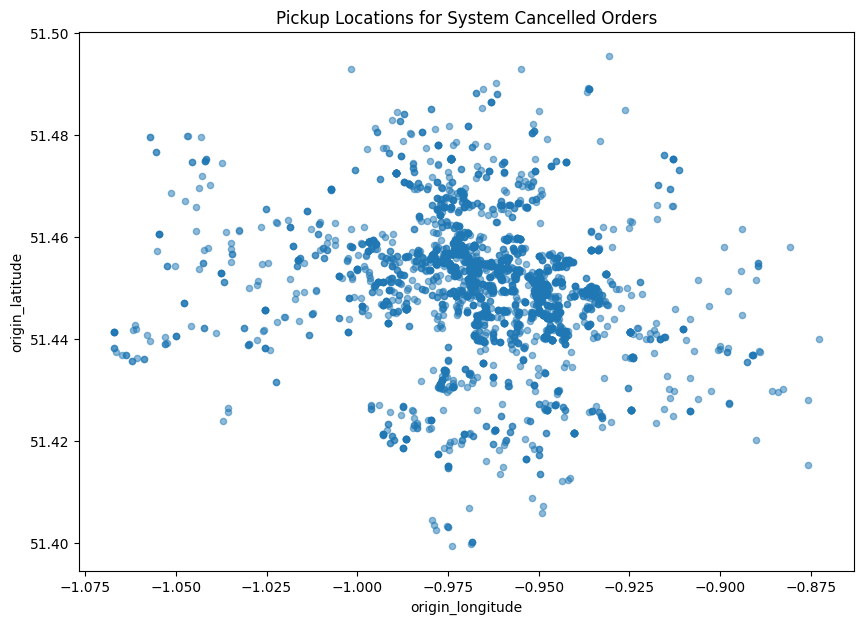

In [46]:
df_q1ciii = offers[offers['order_status_key']=='System cancelled'][['origin_longitude', 'origin_latitude']]
ax = df_q1ciii.plot(kind='scatter', x='origin_longitude', y='origin_latitude', alpha=0.5, figsize=(10, 7))
ax.set_title("Pickup Locations for System Cancelled Orders")

In [56]:
center_lat = df_q1ci['origin_latitude'].mean()
center_lon = df_q1ci['origin_longitude'].mean()
print(f"Center of map: ({center_lat}, {center_lon})")

colour_map = {'Client cancelled': 'blue', 'System cancelled': 'orange'}

m = folium.Map(location=[center_lat, center_lon], zoom_start=13)
for _, row in df_q1ci.iterrows():
    folium.CircleMarker(
        location=[row['origin_latitude'], row['origin_longitude']],
        radius=1,
        color=colour_map[row['order_status_key']],
        fill=True,
        fill_opacity=0.3
    ).add_to(m)

m.save("pick_up_locations_map.html")
m

Center of map: (51.45054119578201, -0.9643232313363195)


Below is a screenshot:
![Alt text](pick_up_locations_map.png)

Both scatter plots for system cancelled and client cancelled rides look similar.
The scatter plot is largely clustered around the center, at Reading town.  
The terrain seems to be roads with a river running across in the middle. More research on the terrain traffic for a conclusion in needed. Note that that larger cluster of failed orders could just be a problem of scale, due a larger total number of order in the center region compared to the less crowded sides.

## 2. Distribution of failed orders by hour of day

In [48]:
offers['order_hour'] = offers['order_time'].dt.hour

In [49]:
# check if hour extraction is correct
offers.sample(5, random_state=1)[['order_time', 'order_hour']]

order_time  order_hour
1569 1900-01-01 14:55:33          14
674  1900-01-01 20:41:30          20
6586 1900-01-01 01:00:07           1
3272 1900-01-01 23:52:31          23
2900 1900-01-01 13:17:04          13

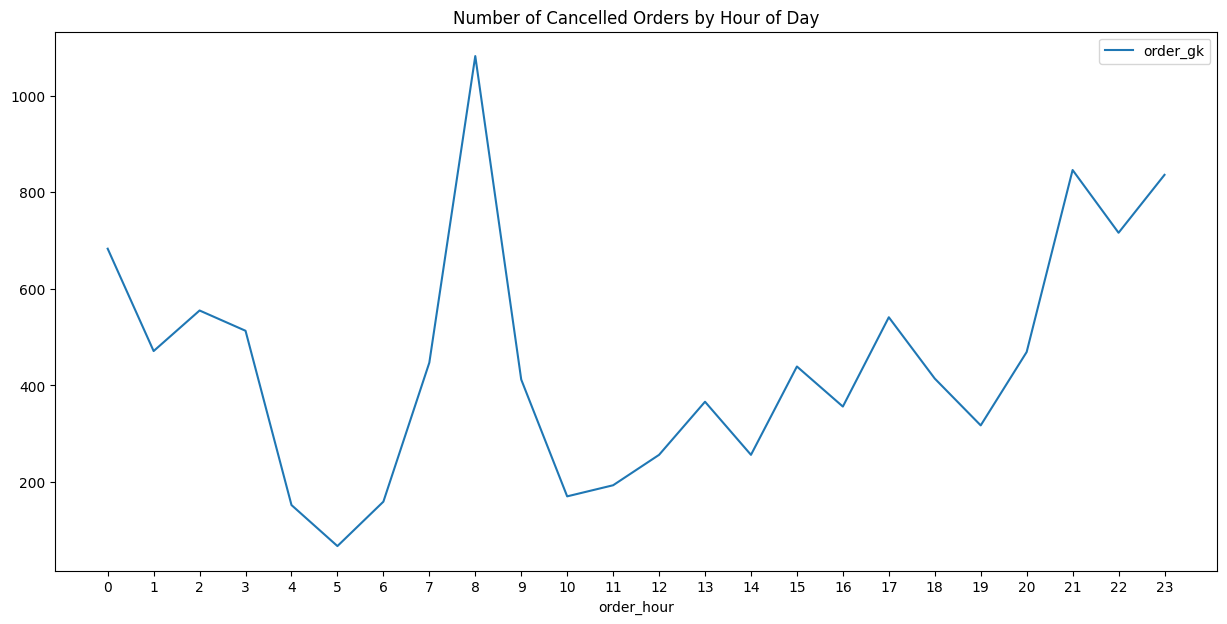

In [50]:
df_q2a = offers.pivot_table(index='order_hour', values='order_gk', aggfunc='count')
ax = df_q2a.plot(kind='line', subplots=False, figsize=(15, 7), rot=0,
                 title='Number of Cancelled Orders by Hour of Day',
                 xticks=range(0, 24))

Highest number of failed orders at 8am, followed by the period at night from 9pm to 12am.

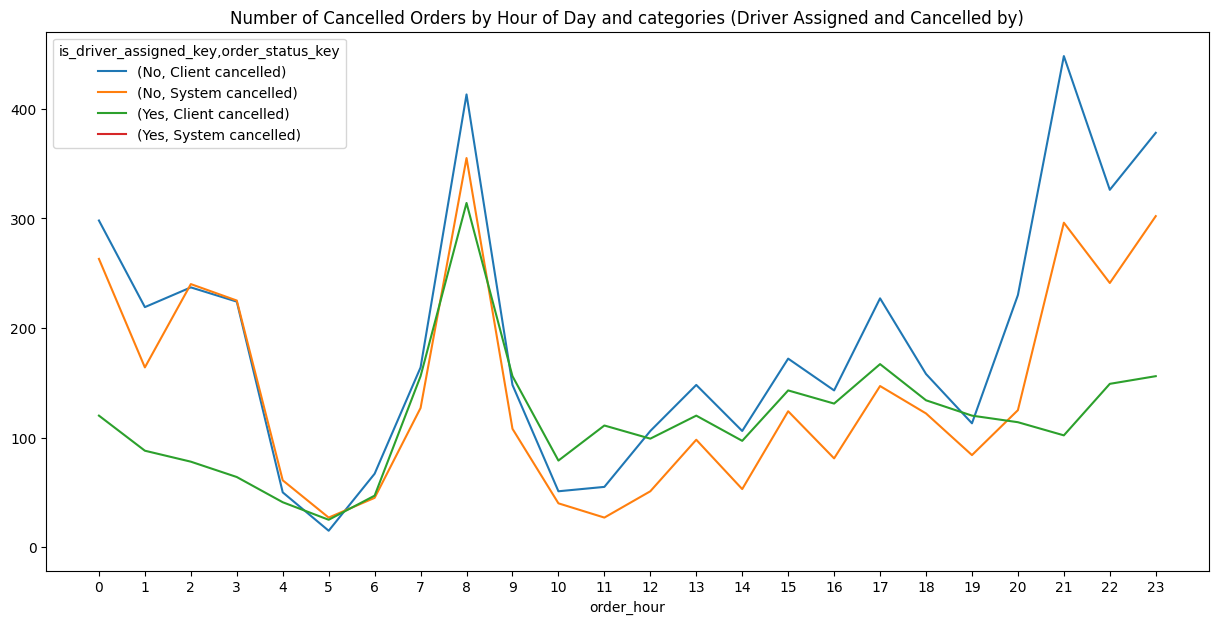

In [51]:
df_q2b = offers.pivot_table(index=['order_hour'], columns=['is_driver_assigned_key', 'order_status_key'], values='order_gk', aggfunc='count')
ax = df_q2b.plot(kind='line', subplots=False, figsize=(15, 7), rot=0,
                 title='Number of Cancelled Orders by Hour of Day and categories (Driver Assigned and Cancelled by)',
                 xticks=range(0, 24))

In [52]:
# Show only rows for ('Yes', 'System cancelled') and filter out NaN values
filtered_df = df_q2b.loc[:, ('Yes', 'System cancelled')].dropna()
filtered_df

order_hour
0     2.0
16    1.0
Name: (Yes, System cancelled), dtype: float64

In general, all categories follow a similar trend except for the night from 7pm to 12am.
- The peak of failed orders at 8am might be due to natural scaling of failed orders from a larger total number of orders due to the morning commute peak hour.
- The night peak of failed orders is likely due to lack of drivers assigned.

## 3. Average time to cancellation with and without driver

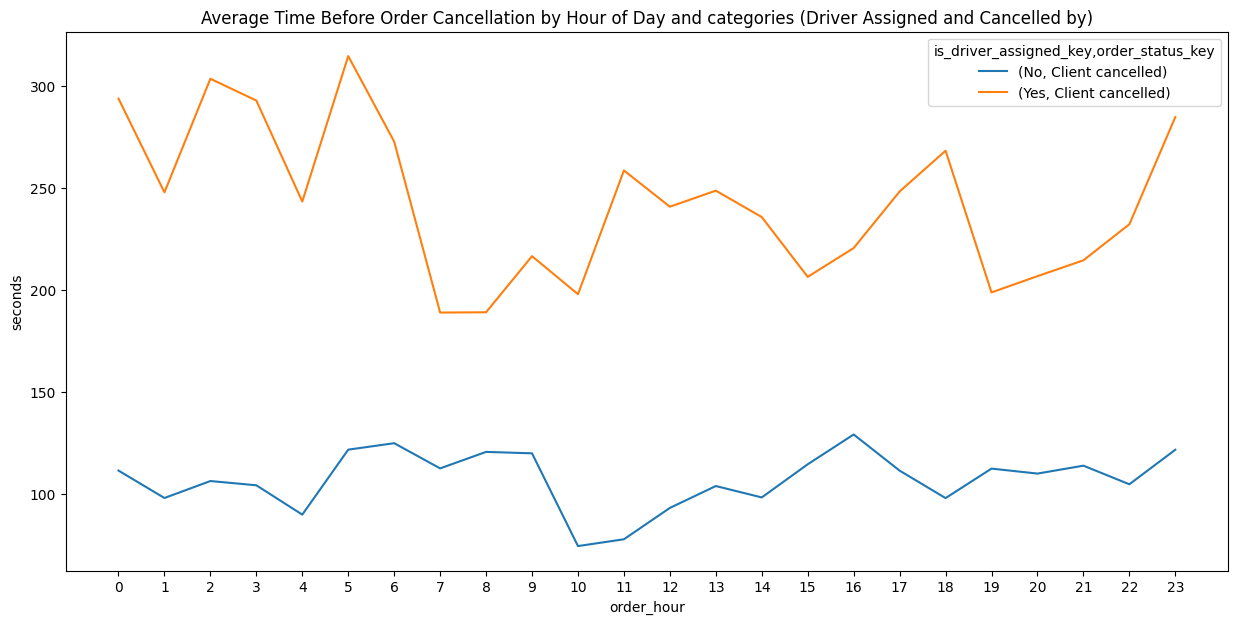

In [53]:
# find average time before order cancellation by hours of day
avg_cancel_time = offers.pivot_table(index='order_hour', columns=['is_driver_assigned_key', 'order_status_key'], values='cancellations_time_in_seconds', aggfunc='mean')
ax = avg_cancel_time.plot(kind='line', subplots=False, figsize=(15, 7), rot=0,
                          title='Average Time Before Order Cancellation by Hour of Day and categories (Driver Assigned and Cancelled by)',
                          xticks=range(0, 24),
                          ylabel='seconds')

All client cancelled rides without driver assigned waited >= 200 seconds to be assigned a driver before cancelling.  
Average time before cancellation is higher on orders with driver assigned than without for each hour.

## 4. Average ETA by hour of day

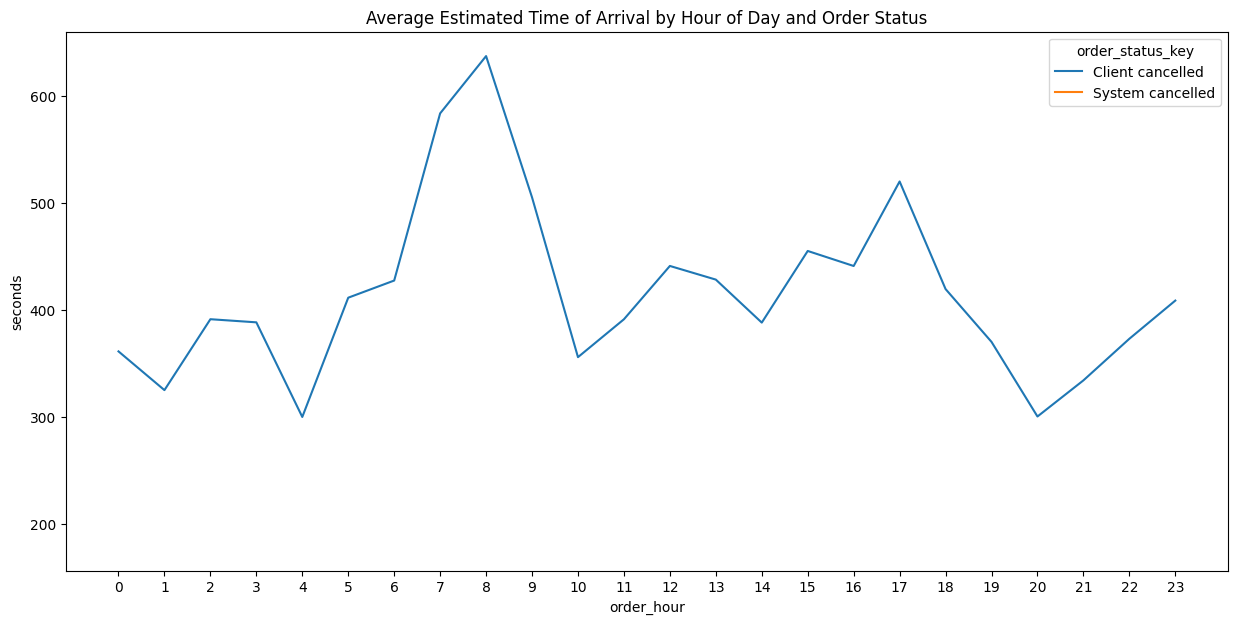

In [54]:
avg_eta = offers.pivot_table(index='order_hour', columns=['order_status_key'], values='m_order_eta', aggfunc='mean')
ax = avg_eta.plot(kind='line', subplots=False, figsize=(15, 7), rot=0,
                 title='Average Estimated Time of Arrival by Hour of Day and Order Status',
                 xticks=range(0, 24),
                 ylabel='seconds')

ETA peaked at around 8am where there are also most numbers of cancelled orders likely due to morning commute peak hour, causing road congestion and longest eta. In line with 8am being the lowest average time waited before client cancellation, this suggests that long ETA is the main reason to client cancellation with driver assigned during the morning peak period. 
